<a href="https://colab.research.google.com/github/danielepiano/AN2DL-First-Challenge-Ibuprofen/blob/main/Test1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set up

Libraries

In [3]:
import os
from datetime import datetime

import copy
import shutil
from itertools import product
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import logging
import random
import numpy as np


# Set seed for reproducibility
SEED = 42

# Set environment variables before importing modules
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(SEED)
random.seed(SEED)

# Import PyTorch
import torch
torch.manual_seed(SEED)
from torch import nn
# from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import TensorDataset, DataLoader
logs_dir = "tensorboard" # ______________________________________________ directory for output file
!pkill -f tensorboard
%load_ext tensorboard
!mkdir -p models

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")


# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

PyTorch version: 2.8.0+cu126
Device: cuda


Download data from google drive

In [4]:
from google.colab import drive

drive.mount("/gdrive")
working_dir = "/gdrive/My Drive/B University/Artificial Networks/an2dl2526c1"
input_dir = working_dir

%cd $working_dir

# print(f"Working at folder: {working_dir}")
# print(f"Input at folder: {input_dir}")

dataset_name = "an2dl2526c1"
dataset_dir = f"{input_dir}"

# Check if data directory exists
if not os.path.exists(dataset_dir):
    print(f"Error: Dataset folder not found for '{dataset_name}' at expected input path: {input_dir}")
# Load data
else:
  # print(f"Dataset folder found for '{dataset_name}': {dataset_dir}")

  try:
      df_features_raw = pd.read_csv(f'{dataset_dir}/pirate_pain_train.csv')
      df_labels_raw = pd.read_csv(f'{dataset_dir}/pirate_pain_train_labels.csv')
      df_test_raw = pd.read_csv(f'{dataset_dir}/pirate_pain_test.csv')
  except FileNotFoundError as e:
        print(f"Error: CSV file {e.filename} not found at expected data path: {dataset_dir}")
  print(f"Dataset '{dataset_name}' loaded successfully")

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/B University/Artificial Networks/an2dl2526c1
Dataset 'an2dl2526c1' loaded successfully


# Data-set Modification


In [5]:
label_mapping = { # I CHANGE the label_mapping
    'no_pain': 2,
    'low_pain': 1,
    'high_pain': 0
}
pain_survey_cols = ['pain_survey_1', 'pain_survey_2', 'pain_survey_3', 'pain_survey_4']
body_parts_cols = ['n_legs', 'n_hands', 'n_eyes']
joint_cols = [f'joint_{i:02d}' for i in range(31)] # _______________joint_00 to joint_31 !!!!!!!!!!!!!!

#__________________________________________________________________________ djoint

# One-hot encode pain_survey columns and replace them in df_features __________________ ONE ENCODE pain surveys
#df_features = df_features_raw.copy()
#df_test = df_test_raw.copy()

df_features = df_features_raw.copy()
df_labels = df_labels_raw.copy()
df_labels['label'] = df_labels_raw['label'].map(label_mapping)

df_test = df_test_raw.copy()

df_features[joint_cols] = df_features[joint_cols].astype(np.float32)
df_test[joint_cols] = df_test[joint_cols].astype(np.float32)

# Convert pain_survey_cols and body_parts_cols to numeric, coercing errors to NaN
for col in pain_survey_cols + body_parts_cols:
    df_features[col] = pd.to_numeric(df_features[col], errors='coerce')
    df_test[col] = pd.to_numeric(df_test[col], errors='coerce')

# Fill NaN values that might have been introduced by 'coerce' with 0
df_features[pain_survey_cols + body_parts_cols] = df_features[pain_survey_cols + body_parts_cols].fillna(0)
df_test[pain_survey_cols + body_parts_cols] = df_test[pain_survey_cols + body_parts_cols].fillna(0)
#___________________________________________________________________________

# The function make_loader() is a convenience wrapper or creating a PyTorch DataLoader with some performance optimizations.
# This function helps: Reduce data loading latency _ Keep your GPU fully utilized _ Make training smoother and faster
# An epoch is one full pass of your training dataset through the neural network.
#If your dataset has 10,000 samples and your batch size is 100, → one epoch = 100 mini-batches × 100 samples = 10,000 total samples processed once.

# INPUT function's PARAMETERS:_______________________
# ds: Your dataset (usually a torch.utils.data.Dataset subclass).
# batch_size: Number of samples per mini-batch.
# shuffle: Whether to randomly shuffle data (True for training).
# drop_last: Whether to drop the last incomplete batch (useful for consistent batch sizes).
# ___________________________________________________
# SIMPLEST VERSION OF the same concept:
# DataLoader(ds, batch_size=32, shuffle=True)
#____________________________________________________
def make_loader(ds, batch_size, shuffle, drop_last):
    # Determine optimal number of worker processes for data loading
    cpu_cores = os.cpu_count() or 2
    num_workers = max(2, min(4, cpu_cores))

    # Create DataLoader with performance optimizations
    return DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers,
        pin_memory=True,  # Faster GPU transfer
        pin_memory_device="cuda" if torch.cuda.is_available() else "",
        prefetch_factor=4,  # Load 4 batches ahead
    )


Modifiche peso

In [6]:
# Replace "two" with 2, everything else with 1
# ___________________________________________________ I NEED to do this because I want numerical values in K_SHUFFLE
df_features[['n_hands', 'n_legs', 'n_eyes']] = df_features[['n_hands', 'n_legs', 'n_eyes']].applymap(lambda x: 2 if x == "two" else 1)


# ___________________________________________________
# temporal_cols = pain_survey_cols + body_parts_cols + joint_cols

# pain_survey_cols = ['pain_survey_1', 'pain_survey_2', 'pain_survey_3', 'pain_survey_4']
# body_parts_cols = ['n_legs', 'n_hands', 'n_eyes']
# joint_cols = [f'joint_{i:02d}' for i in range(31)] # _______________joint_00 to joint_31 !!!!!!!!!!!!!!
# df_features = df_features_raw.copy()
# ___________________________________________________
# definisci qui il numero feature così n0on lo modifichi più
# funzioni:
# build_sequences(df_features, df_labels=None, window=160, stride=160):
# k_shuffle_split_cross_validation_round_rnn ---> in_feature =38
# Produce file to Submission --->  Reccurrent Classifeir  ---> input_size= 38

"""
pain_survey_cols = ['pain_survey_1', 'pain_survey_2', 'pain_survey_3', 'pain_survey_4']
body_parts_cols = ['n_legs', 'n_hands', 'n_eyes']

cols_to_remove = [
    "joint_13", "joint_14", "joint_15", "joint_16",
    "joint_17", "joint_18", "joint_19", "joint_20",
    "joint_21", "joint_22", "joint_23", "joint_24",
    "joint_25", "joint_30"
]

df_features = df_features.drop(columns=cols_to_remove, errors="ignore")

# Rebuild joint_cols dynamically
joint_cols = [col for col in df_features.columns if col.startswith("joint_")]
"""
cols_to_remove = [
    "n_legs", "n_hands", "n_eyes", "joint_30"
]
df_features = df_features.drop(columns=cols_to_remove, errors="ignore")

# Rebuild joint_cols dynamically
joint_cols = [col for col in df_features.columns if col.startswith("joint_")]
body_parts_cols = []




In [7]:
# Define a function to build sequences from the dataset
def build_sequences(df_features, df_labels=None, window=160, stride=160):
    """
    Builds sequences from time series data using a sliding window approach.

    Args:
        df_features (pd.DataFrame): DataFrame with time series features.
                                    Must contain 'sample_index' and 'time' columns,
                                    and the features specified in pain_survey_ohenceded_cols, joint_cols and djoint_cols.
        df_labels (pd.DataFrame, optional): DataFrame with labels.
                                           Must contain 'sample_index' and 'label' columns.
                                           Defaults to None.
        window (int): The size of the sliding window.
        stride (int): The step size for the sliding window.

    Returns:
        tuple: (dataset, labels, sample_indices) - Numpy arrays of sequences,
               corresponding labels (if df_labels is provided), and original sample indices
               for each sequence.
    """
    # Sanity check to ensure the window is divisible by the stride
    assert window % stride == 0, "Window must be divisible by stride"

    # Initialise lists to store sequences, their corresponding labels, and original sample indices
    #  temporal_cols = pain_survey_ohenceded_cols + joint_cols + djoint_cols
    #  _______________________________________________________________________________________________ colonne tabella !!!!!!!!!!!
    temporal_cols = pain_survey_cols + body_parts_cols + joint_cols
    dataset = []
    labels = []
    sequence_sample_indices = [] # Store the original sample index for each sequence

    # Iterate over unique IDs in the DataFrame
    sample_indices = df_features['sample_index'].unique()
    for id in sample_indices:
        # Extract data for the current ID
        temp_df = df_features[df_features['sample_index'] == id].copy() # Use copy to avoid SettingWithCopyWarning
        temp = temp_df[temporal_cols].values


        # Retrieve the pain label for the current ID
        if df_labels is not None:
          label = df_labels[df_labels['sample_index'] == id]['label'].values[0]

        # Calculate padding length to ensure full windows
        # This padding is needed to ensure the last window captures the end of the sequence
        padding_len = window - len(temp) % window
        if padding_len > 0 and padding_len != window: # Avoid adding full window of padding if sequence length is already a multiple of window
             padding = np.zeros((padding_len, len(temporal_cols)), dtype='float32')
             temp = np.concatenate((temp, padding))

        # Build feature windows and associate them with labels and sample index
        idx = 0
        while idx + window <= len(temp):
            dataset.append(temp[idx:idx + window])
            if df_labels is not None:
              labels.append(label)
            sequence_sample_indices.append(id) # Append the original sample index
            idx += stride

    # Convert lists to numpy arrays for further processing
    dataset = np.array(dataset)
    labels = np.array(labels)
    sequence_sample_indices = np.array(sequence_sample_indices)

    if df_labels is not None:
        return dataset, labels, sequence_sample_indices
    else:
        return dataset, sequence_sample_indices # Return only dataset and sample indices for test data

# 🛠️ Model functions

In [8]:

class RecurrentClassifier(nn.Module):
    """
    Generic RNN classifier (RNN, LSTM, GRU).
    Uses the last hidden state for classification.
    """
    def __init__(
            self,
            input_size,  # _________________________________________________________________ INPUT INPPUT INPUT !!!!!!!!!!!!!!!
            hidden_size,
            num_layers,
            num_classes,
            rnn_type='RNN',        # 'RNN', 'LSTM', or 'GRU'
            bidirectional=False,
            dropout_rate=0.2
            ):
        super().__init__()

        self.rnn_type = rnn_type
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.bidirectional = bidirectional

        # Map string name to PyTorch RNN class
        rnn_map = {
            'RNN': nn.RNN,
            'LSTM': nn.LSTM,
            'GRU': nn.GRU
        }

        if rnn_type not in rnn_map:
            raise ValueError("rnn_type must be 'RNN', 'LSTM', or 'GRU'")

        rnn_module = rnn_map[rnn_type]

        # Dropout is only applied between layers (if num_layers > 1)
        dropout_val = dropout_rate if num_layers > 1 else 0

        # Create the recurrent layer
        self.rnn = rnn_module(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,       # Input shape: (batch, seq_len, features)
            bidirectional=bidirectional,
            dropout=dropout_val
        )

        # Calculate input size for the final classifier
        if self.bidirectional:
            classifier_input_size = hidden_size * 2 # Concat fwd + bwd
        else:
            classifier_input_size = hidden_size

        # Final classification layer
        self.classifier = nn.Linear(classifier_input_size, num_classes)

    def forward(self, x):
        """
        x shape: (batch_size, seq_length, input_size)
        """

        # rnn_out shape: (batch_size, seq_len, hidden_size * num_directions)
        rnn_out, hidden = self.rnn(x)

        # LSTM returns (h_n, c_n), we only need h_n
        if self.rnn_type == 'LSTM':
            hidden = hidden[0]

        # hidden shape: (num_layers * num_directions, batch_size, hidden_size)

        if self.bidirectional:
            # Reshape to (num_layers, 2, batch_size, hidden_size)
            hidden = hidden.view(self.num_layers, 2, -1, self.hidden_size)

            # Concat last fwd (hidden[-1, 0, ...]) and bwd (hidden[-1, 1, ...])
            # Final shape: (batch_size, hidden_size * 2)
            hidden_to_classify = torch.cat([hidden[-1, 0, :, :], hidden[-1, 1, :, :]], dim=1)
        else:
            # Take the last layer's hidden state
            # Final shape: (batch_size, hidden_size)
            hidden_to_classify = hidden[-1]

        # Get logits
        logits = self.classifier(hidden_to_classify)
        return logits

In [9]:

def train_one_epoch(model, train_loader, criterion, optimizer, scaler, device, l1_lambda=0, l2_lambda=0, max_grad_norm=1.0):
    """
    Perform one complete training epoch through the entire training dataset (one epoch).

    Parameters:
    model: your neural net.
    train_loader: batches of data (from your DataLoader).
    criterion: loss function (e.g. CrossEntropyLoss).
    optimizer: algorithm to update weights (e.g. Adam, SGD).
    scaler: for mixed precision training (saves GPU memory and speeds up training).
    device: 'cuda' or 'cpu'.
    l1_lambda, l2_lambda: regularization strengths.
    max_grad_norm: used for the max gradient for gradient clipping (prevents exploding gradients).

    Returns:
    tuple: (average_loss, f1 score) - Training loss and f1 score for this epoch
    """
    model.train()  # Set model to training mode

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    # Iterate through training batches
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        # Move data to device (GPU/CPU)
        inputs, targets = inputs.to(device), targets.to(device)

        # Clear gradients from previous step
        optimizer.zero_grad(set_to_none=True)

        # Forward pass with mixed precision (if CUDA available)
        with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
            inputs = inputs.to(torch.float32)
            logits = model(inputs)
            loss = criterion(logits, targets)

            # Add L1 and L2 regularization ______________________________________________________ Why is it done in this way?
            l1_norm = sum(p.abs().sum() for p in model.parameters())
            l2_norm = sum(p.pow(2).sum() for p in model.parameters())
            loss = loss + l1_lambda * l1_norm + l2_lambda * l2_norm


        # Backward pass with gradient scaling, Scales the loss before computing gradients to avoid underflow in float16 mode.
        scaler.scale(loss).backward()


        # Unscale: restores gradients to real values.
        scaler.unscale_(optimizer)
        # Clip gradients: prevents extremely large updates (exploding gradients). _____________________________ GRID CLIPPING
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=max_grad_norm)
        # Step: updates weights.
        scaler.step(optimizer)
        # Update scaler: adjusts scaling dynamically for stable mixed precision.
        scaler.update()

        # Accumulate metrics, Keeps track of total loss and saves predictions for F1 score.
        running_loss += loss.item() * inputs.size(0)
        predictions = logits.argmax(dim=1)
        all_predictions.append(predictions.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

    # Calculates average loss per sample.
    epoch_loss = running_loss / len(train_loader.dataset)
    # _______________________________________________________________________
    # Computes weighted F1 score (balances precision & recall).
    # F1 is particularly useful when:
    # Classes are imbalanced (e.g., 90% negative, 10% positive).
    # You care equally about precision and recall.
    # You don’t want a model that only predicts the majority class.
    # ⚠️ F1 ignores true negatives — that’s important:
    # it focuses only on the positive class performance (good when the “positive” class is rare).

    epoch_f1 = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average='weighted' # # # 'weighted', 'macro' or 'micro'
    )
    # WHY do we use the same F1 score? This way you can compare how well your model generalizes:
    # If train_F1 is high but val_F1 is low → overfitting.
    # If both are low → underfitting or model too weak.
    # If both rise and then plateau → converged.

    return epoch_loss, epoch_f1 # _____________________________who gonna take those metrics?

In [10]:
def validate_one_epoch(model, val_loader, criterion, device):
    """
    Perform one complete validation epoch through the entire validation dataset.

    Args:
        model (nn.Module): The neural network model to evaluate (must be in eval mode)
        val_loader (DataLoader): PyTorch DataLoader containing validation data batches
        criterion (nn.Module): Loss function used to calculate validation loss
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)

    Returns:
        tuple: (average_loss, accuracy) - Validation loss and accuracy for this epoch

    Note:
        This function automatically sets the model to evaluation mode and disables
        gradient computation for efficiency during validation.
    """
    model.eval()  # Set model to evaluation mode

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    # Disable gradient computation for validation
    with torch.no_grad():
        for inputs, targets in val_loader:
            # Move data to device
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass with mixed precision (if CUDA available)
            with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
                inputs = inputs.to(torch.float32)
                logits = model(inputs)
                loss = criterion(logits, targets)

            # Accumulate metrics
            running_loss += loss.item() * inputs.size(0)
            predictions = logits.argmax(dim=1)
            all_predictions.append(predictions.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    # Calculate epoch metrics
    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_accuracy = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average='weighted' # # # 'weighted', 'macro' or 'micro'
    )

    return epoch_loss, epoch_accuracy

In [11]:
def log_metrics_to_tensorboard(writer, epoch, train_loss, train_f1, val_loss, val_f1, model):
    """
    Log training metrics and model parameters to TensorBoard for visualization.

    Args:
        writer (SummaryWriter): TensorBoard SummaryWriter object for logging
        epoch (int): Current epoch number (used as x-axis in TensorBoard plots)
        train_loss (float): Training loss for this epoch
        train_f1 (float): Training f1 score for this epoch
        val_loss (float): Validation loss for this epoch
        val_f1 (float): Validation f1 score for this epoch
        model (nn.Module): The neural network model (for logging weights/gradients)

    Note:
        This function logs scalar metrics (loss/f1 score) and histograms of model
        parameters and gradients, which helps monitor training progress and detect
        issues like vanishing/exploding gradients.
    """
    # Log scalar metrics
    writer.add_scalar('Loss/Training', train_loss, epoch)
    writer.add_scalar('Loss/Validation', val_loss, epoch)
    writer.add_scalar('F1/Training', train_f1, epoch)
    writer.add_scalar('F1/Validation', val_f1, epoch)

    # Log model parameters and gradients
    for name, param in model.named_parameters():
        if param.requires_grad:
            # Check if the tensor is not empty before adding a histogram
            if param.numel() > 0:
                writer.add_histogram(f'{name}/weights', param.data, epoch)
            if param.grad is not None:
                # Check if the gradient tensor is not empty before adding a histogram
                if param.grad.numel() > 0:
                    if param.grad is not None and torch.isfinite(param.grad).all():
                        writer.add_histogram(f'{name}/gradients', param.grad.data, epoch)

In [12]:
def fit(model,
        train_loader,
        val_loader,

        epochs,
        criterion,
        optimizer,

        scaler, # Scaler, gradient scaler for mixed precision training

        device,
        l1_lambda=0, # _________________________________________________L1 = 0??????
        l2_lambda=0,
        patience=0, # __________________________________________________ set up patience??????????????
        evaluation_metric="val_f1", # __________________ again? was already defined???????'
        mode='max',
        restore_best_weights=True,
        writer=None,
        verbose=10,
        experiment_name=""):
    """
    Train the neural network model on the training data and validate on the validation data.

    Args:
        model (nn.Module): The neural network model to train
        train_loader (DataLoader): PyTorch DataLoader containing training data batches
        val_loader (DataLoader): PyTorch DataLoader containing validation data batches
        epochs (int): Number of training epochs
        criterion (nn.Module): Loss function (e.g., CrossEntropyLoss, MSELoss)
        optimizer (torch.optim): Optimization algorithm (e.g., Adam, SGD)
        scaler (GradScaler): PyTorch's gradient scaler for mixed precision training
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)
        l1_lambda (float): L1 regularization coefficient (default: 0)
        l2_lambda (float): L2 regularization coefficient (default: 0)

        patience (int): Number of epochs to wait for improvement before early stopping (default: 0)

        evaluation_metric (str): Metric to monitor for early stopping (default: "val_f1")

        mode (str): 'max' for maximizing the metric, 'min' for minimizing (default: 'max')

        restore_best_weights (bool): Whether to restore model weights from best epoch (default: True)

        writer (SummaryWriter, optional): TensorBoard SummaryWriter object for logging (default: None)

        verbose (int, optional): Frequency of printing training progress (default: 10)

        experiment_name (str, optional): Experiment name for saving models (default: "")

    Returns:
        tuple: (model, training_history) - Trained model and metrics history
    """

    # Initialize metrics tracking
    training_history = {
        'train_loss': [], 'val_loss': [],
        'train_f1': [], 'val_f1': []
    }

    # Configure early stopping if patience is set
    if patience > 0:
        patience_counter = 0
        best_metric = float('-inf') if mode == 'max' else float('inf')
        best_epoch = 0

    print(f"Training {epochs} epochs...")

    # Main training loop: iterate through epochs
    for epoch in range(1, epochs + 1):

        # _________________________________________________________________________ TRAIN_one_epoch
        # Forward pass through training data, compute gradients, update weights
        train_loss, train_f1 = train_one_epoch(
            model, train_loader, criterion, optimizer, scaler, device, l1_lambda, l2_lambda
        )
        # _________________________________________________________________________ VALIDATE_one_epoch
        # Evaluate model on validation data without updating weights
        val_loss, val_f1 = validate_one_epoch(
            model, val_loader, criterion, device
        )

        # Store metrics for plotting and analysis
        training_history['train_loss'].append(train_loss)
        training_history['val_loss'].append(val_loss)
        training_history['train_f1'].append(train_f1)
        training_history['val_f1'].append(val_f1)

        # Write metrics to TensorBoard for visualization
        if writer is not None:
            log_metrics_to_tensorboard(
                writer, epoch, train_loss, train_f1, val_loss, val_f1, model
            )
         # Print progress every N epochs or on first epoch
        if verbose > 0:
            if epoch % verbose == 0 or epoch == 1:
                print(f"Epoch {epoch:3d}/{epochs} | "
                    f"Train: Loss={train_loss:.4f}, F1 Score={train_f1:.4f} | "
                    f"Val: Loss={val_loss:.4f}, F1 Score={val_f1:.4f}")

        # __________________________________________________________  EARLY STOPPING logic: monitor metric and save best model
        if patience > 0:
            current_metric = training_history[evaluation_metric][-1]
            is_improvement = (current_metric > best_metric) if mode == 'max' else (current_metric < best_metric)

            if is_improvement:
                best_metric = current_metric
                best_epoch = epoch
                torch.save(model.state_dict(), "models/"+experiment_name+'_model.pt')
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping triggered after {epoch} epochs.")
                    break

    # Restore best model weights if early stopping was used
    if restore_best_weights and patience > 0:
        model.load_state_dict(torch.load("models/"+experiment_name+'_model.pt'))
        print(f"Best model restored from epoch {best_epoch} with {evaluation_metric} {best_metric:.4f}")

    # Save final model if no early stopping
    if patience == 0:
        torch.save(model.state_dict(), "models/"+experiment_name+'_model.pt')

    # Close TensorBoard writer
    if writer is not None:
        writer.close()

    return model, training_history

# 🔀 K-Shuffle-Split Cross Validation functions




In [13]:
def k_shuffle_split_cross_validation_round_rnn(
    df,
    df_labels,
    epochs,
    criterion,
    device,
    k,
    test_size,
    batch_size,
    hidden_layers,
    hidden_size,
    learning_rate,
    dropout_rate,

    window_size, #_____________________________ to eliminate

    stride,
    rnn_type,
    bidirectional,
    l1_lambda=0,
    l2_lambda=0,
    patience=0,
    evaluation_metric="val_f1",
    mode='max',
    restore_best_weights=True,
    writer=None,
    verbose=10, seed=42, experiment_name=""
    ):
    """
    Perform K-fold shuffle split cross-validation with user-based splitting for time series data.

    Args:
        df: DataFrame with columns ['sample_index', 'time', *pain_survey_ohenceded_cols, *joint_cols, *djoint_cols]
        df_labels: DataFrame with columns ['label']
        epochs: Number of training epochs
        criterion: Loss function
        device: torch.device for computation

        k: Number of cross-validation splits

        test_size: Number of users or fraction of users for validation set

        batch_size: Batch size for training

        hidden_layers: Number of recurrent layers

        hidden_size: Hidden state dimensionality

        learning_rate: Learning rate for optimizer
        dropout_rate: Dropout rate

        window_size: Length of sliding windows # ____________________________NON L'HO MESSA

        stride: Step size for sliding windows
        rnn_type: Type of RNN ('RNN', 'LSTM', 'GRU')
        bidirectional: Whether to use bidirectional RNN
        l1_lambda: L1 regularization coefficient (if used)
        l2_lambda: L2 regularization coefficient (weight_decay)
        patience: Early stopping patience
        evaluation_metric: Metric to monitor for early stopping
        mode: 'max' or 'min' for evaluation metric
        restore_best_weights: Whether to restore best weights after training
        writer: TensorBoard writer
        verbose: Verbosity level
        seed: Random seed
        experiment_name: Name for experiment logging

    Returns:
        fold_losses: Dict with validation losses for each split
        fold_metrics: Dict with validation F1 scores for each split
        best_scores: Dict with best F1 score for each split plus mean and std
        best_model: Best model among the K-Shuffle-Splits
        best_experiment_name: Experiment name of the best model
    """

    # Initialize best model tracking variables
    best_model = None
    best_experiment_name = None
    best_performance = float('-inf')

    # Initialise containers for results across all splits
    fold_losses = {}
    fold_metrics = {}
    best_scores = {}

    # Get model architecture parameters
    # ORGINAL ____ INPUT size ___
    # in_features = len(pain_survey_ohenceded_cols) + len(joint_cols) + len(djoint_cols)  # __________________MODIFY INPUT SIZE
    # ____________________________________________________________________  MY VERSION  ______________________
    # Corrected in_features to reflect actual feature columns
    in_features = len(pain_survey_cols) + len(body_parts_cols) + len(joint_cols)  # _____________________________!!!!!!!!!!
    num_classes = len(df_labels['label'].unique())

# Initialise model architecture
    model = RecurrentClassifier(
        input_size=in_features, # Use the correctly calculated in_features
        hidden_size=hidden_size,
        num_layers=hidden_layers,
        num_classes=num_classes,
        dropout_rate=dropout_rate,
        bidirectional=bidirectional,
        rnn_type=rnn_type
    ).to(device)

    # Store initial weights to reset model for each split
    initial_state = copy.deepcopy(model.state_dict())


     # Iterate through K random splits
    for split_idx in range(k):

        if verbose > 0:
            print(f"Split {split_idx+1}/{k}")

        # Randomly split sample_indices for training and validation
        train_users, val_users, train_labels, val_labels = train_test_split(
            df_labels['sample_index'], df_labels['label'],
            test_size=test_size,
            random_state=SEED+split_idx, # enforce randomness for each split
            stratify=df_labels['label'] # stratify by pain labels frequency
        )

        # Split the dataset into training and validation sets based on sample indices
        df_train = df[df['sample_index'].isin(train_users)].copy()
        df_val = df[df['sample_index'].isin(val_users)].copy()
        df_train_labels = df_labels[df_labels['sample_index'].isin(train_users)].copy()
        df_val_labels = df_labels[df_labels['sample_index'].isin(val_users)].copy()

        if verbose > 0:
            print(f"  Training set shape: {df_train.shape}")
            print(f"  Validation set shape: {df_val.shape}")

        # Normalise features using training set statistics
        # to_norm_features = [*joint_cols, *djoint_cols]
        to_norm_features = [*joint_cols]
        train_max = df_train[to_norm_features].max()
        train_min = df_train[to_norm_features].min()
        df_train[to_norm_features] = (df_train[to_norm_features] - train_min) / (train_max - train_min + 1e-8)
        df_val[to_norm_features] = (df_val[to_norm_features] - train_min) / (train_max - train_min + 1e-8)

        # Build sequences using the existing build_sequences function
        X_train, y_train, _ = build_sequences(df_train, df_train_labels, window=window_size, stride=stride)
        X_val, y_val, _ = build_sequences(df_val, df_val_labels, window=window_size, stride=stride)


        if verbose > 0:
            print(f"  Training sequences shape: {X_train.shape}")
            print(f"  Validation sequences shape: {X_val.shape}")

        # Create PyTorch datasets
        train_ds = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
        val_ds   = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val))

        # Create data loaders
        train_loader = make_loader(train_ds, batch_size=batch_size, shuffle=True, drop_last=False)
        val_loader   = make_loader(val_ds, batch_size=batch_size, shuffle=False, drop_last=False)

        # Reset model to initial weights for fair comparison across splits
        model.load_state_dict(initial_state)

        # Define optimizer with L2 regularization
        optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=l2_lambda)

        # Enable mixed precision training for GPU acceleration
        split_scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

        # Create directory for model checkpoints
        os.makedirs(f"models/{experiment_name}", exist_ok=True)
        # Hierarchical experiment name
        split_experiment_name = f"{experiment_name}/split_{split_idx}"

        # Train model on current split
        model, training_history = fit(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            epochs=epochs,
            criterion=criterion,
            optimizer=optimizer,
            scaler=split_scaler,
            device=device,
            writer=writer,
            patience=patience,
            verbose=verbose,
            l1_lambda=l1_lambda,
            evaluation_metric=evaluation_metric,
            mode=mode,
            restore_best_weights=restore_best_weights,
            experiment_name=split_experiment_name
        )

        # Store results for this split
        fold_losses[f"split_{split_idx}"] = training_history['val_loss']
        fold_metrics[f"split_{split_idx}"] = training_history['val_f1']
        best_scores[f"split_{split_idx}"] = max(training_history['val_f1'])

        # Update best model if current performance is superior
        if best_scores[f"split_{split_idx}"] > best_performance:
            best_model = model
            best_experiment_name = split_experiment_name
            best_performance = best_scores[f"split_{split_idx}"]

    # Compute mean and standard deviation of best scores across splits
    best_scores["mean"] = np.mean([best_scores[k] for k in best_scores.keys() if k.startswith("split_")])
    best_scores["std"] = np.std([best_scores[k] for k in best_scores.keys() if k.startswith("split_")])


    if verbose > 0:
        print(f"Best score: {best_scores['mean']:.4f}±{best_scores['std']:.4f}")

    return fold_losses, fold_metrics, best_scores, best_model, best_experiment_name

#  Hyperparameter tuning functions

GRID SEARCH

Hyper parameter tuning

Plot results : plot_top_configurations_rnn


# Base run

In [14]:
# @title Configuration
# Cross-validation
K = 3                    # Number of splits (5 and 10 are considered good values)
VAL_SIZE = 99            # Size or fraction for validation splits

# Training
EPOCHS = 10000           # Maximum epochs (increase to improve performance)
PATIENCE = 100           # Early stopping patience (increase to improve performance)
VERBOSE = 10             # Print frequency

# Optimisation
LEARNING_RATE = 1e-3     # Learning rate
BATCH_SIZE = 32          # Batch size
WINDOW_SIZE = 40          # Input window size
STRIDE = 20             # Input stride

# Architecture
HIDDEN_LAYERS = 2        # Hidden layers
HIDDEN_SIZE = 64         # Neurons per layer
RNN_TYPE = 'LSTM'         # Type of RNN architecture
BIDIRECTIONAL = False     # Bidirectional RNN

# Regularisation
DROPOUT_RATE = 0         # Dropout probability
L1_LAMBDA = 0            # L1 penalty
L2_LAMBDA = 0            # L2 penalty

# Loss function
ALPHA = 0.1              # Smoothing applied on the loss (between 0 and 1)
CLASS_WEIGHTS_LIST = [0.43, 2.32, 4.0]
CLASS_WEIGHTS = torch.tensor(CLASS_WEIGHTS_LIST, dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(label_smoothing=ALPHA, weight=CLASS_WEIGHTS)


# Experiment name
base_experiment_name = f'{str(datetime.now())}_14_nov_baseline'
# Setup TensorBoard writer
writer = SummaryWriter("./"+logs_dir+"/"+base_experiment_name)

# Initialize best model tracking variables
best_model = None
best_experiment_name = None
best_performance = float('-inf')

In [15]:
# @title Run
%%time
# _______________________________________________________Execute K-fold cross-validation
# __________________with baseline configuration

losses, metrics, best_scores, best_model, best_experiment_name = k_shuffle_split_cross_validation_round_rnn(

    df=df_features,
    df_labels=df_labels,
    epochs=EPOCHS,

    criterion=criterion,
    device=device,
    k=K,
    batch_size=BATCH_SIZE,

    hidden_layers=HIDDEN_LAYERS,
    hidden_size = HIDDEN_SIZE,
    learning_rate=LEARNING_RATE,
    dropout_rate=DROPOUT_RATE,
    l1_lambda=L1_LAMBDA,
    l2_lambda=L2_LAMBDA,

    verbose=VERBOSE,
    patience=PATIENCE,
    seed=SEED,
    experiment_name=base_experiment_name,
    test_size=VAL_SIZE,
    window_size=WINDOW_SIZE,
    stride=STRIDE,
    rnn_type=RNN_TYPE,
    bidirectional=BIDIRECTIONAL,
    writer=writer
)

final_best_params = {
  'k': K,
  'test_size': VAL_SIZE,
  'epochs': EPOCHS,
  'patience': PATIENCE,
  'verbose': 0,
  'learning_rate': LEARNING_RATE,
  'batch_size': BATCH_SIZE,
  'window_size': WINDOW_SIZE,
  'stride': STRIDE,
  'hidden_layers': HIDDEN_LAYERS,
  'hidden_size': HIDDEN_SIZE,
  'rnn_type': RNN_TYPE,
  'bidirectional': BIDIRECTIONAL,
  'dropout_rate': DROPOUT_RATE,
  'l1_lambda': L1_LAMBDA,
  'l2_lambda': L2_LAMBDA,
  'criterion': criterion,
  'device': device,
  'seed': SEED
}

Split 1/3
  Training set shape: (89920, 36)
  Validation set shape: (15840, 36)
  Training sequences shape: (3934, 40, 34)
  Validation sequences shape: (693, 40, 34)
Training 10000 epochs...
Epoch   1/10000 | Train: Loss=0.4568, F1 Score=0.6730 | Val: Loss=0.4229, F1 Score=0.6806
Epoch  10/10000 | Train: Loss=0.3328, F1 Score=0.7705 | Val: Loss=0.3110, F1 Score=0.8081
Epoch  20/10000 | Train: Loss=0.2514, F1 Score=0.8499 | Val: Loss=0.2605, F1 Score=0.8547
Epoch  30/10000 | Train: Loss=0.2074, F1 Score=0.9058 | Val: Loss=0.2765, F1 Score=0.8653
Epoch  40/10000 | Train: Loss=0.1914, F1 Score=0.9238 | Val: Loss=0.2640, F1 Score=0.8932
Epoch  50/10000 | Train: Loss=0.1749, F1 Score=0.9535 | Val: Loss=0.2687, F1 Score=0.9046
Epoch  60/10000 | Train: Loss=0.1740, F1 Score=0.9542 | Val: Loss=0.2310, F1 Score=0.9151
Epoch  70/10000 | Train: Loss=0.1682, F1 Score=0.9666 | Val: Loss=0.2463, F1 Score=0.9140
Epoch  80/10000 | Train: Loss=0.1748, F1 Score=0.9625 | Val: Loss=0.2354, F1 Score=0.928

# Plot

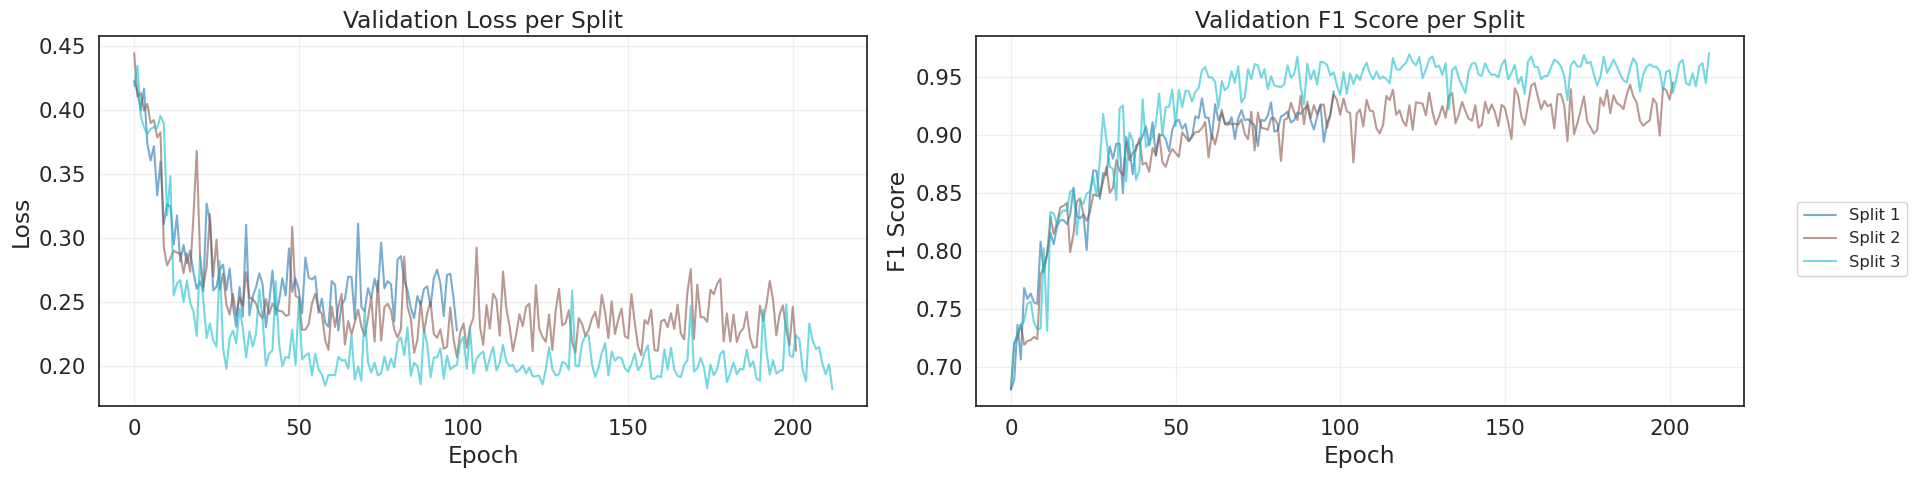

In [16]:
# @title Plot history
# Create figure with two subplots sharing x axis

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 5), sharex=True)

# Color palette for K splits
colors = plt.cm.get_cmap('tab10', K)

# Plot validation loss for each split
for split in range(K):
    axes[0].plot(losses[f'split_{split}'][:-PATIENCE], label=f'Split {split+1}',
                 color=colors(split), alpha=0.6)
axes[0].set_title('Validation Loss per Split')
axes[0].set_ylabel('Loss')
axes[0].set_xlabel('Epoch')
axes[0].grid(alpha=0.3)

# Plot validation F1 score for each split
for split in range(K):
    axes[1].plot(metrics[f'split_{split}'][:-PATIENCE], label=f'Split {split+1}',
                 color=colors(split), alpha=0.6)
axes[1].set_title('Validation F1 Score per Split')
axes[1].set_ylabel('F1 Score')
axes[1].set_xlabel('Epoch')
axes[1].grid(alpha=0.3)

# Add shared legend on the right
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(right=0.975)
plt.show()

# Produce file to Submission

In [17]:
# REQUIRED TO PROCEED:
# - final_best_params         with the whole model configuration
# - best_experiment_name      path to retrieve the model from


# ==============================================================================
#  RELOAD THE BEST MODEL AND ITS STATE
# ==============================================================================
# Rebuild an equivalent model
inference_model = RecurrentClassifier(
        input_size= len(pain_survey_cols) + len(joint_cols) + len(body_parts_cols),
        num_classes=len(label_mapping), # (3)
        hidden_size=final_best_params['hidden_size'],
        num_layers=final_best_params['hidden_layers'],
        dropout_rate=final_best_params['dropout_rate'],
        bidirectional=final_best_params['bidirectional'],
        rnn_type=final_best_params['rnn_type']
    ).to(device)

# Reload the weights of the specified model
inference_model_path = f"models/{best_experiment_name}_model.pt"
inference_model.load_state_dict(torch.load(inference_model_path, map_location=device))
print(f"Model loaded successfully from '{best_experiment_name}' as inference model")



# ==============================================================================
#  INFERENCE
# ==============================================================================
# Normalise features using training set statistics#_________________________________________to check
# to_norm_features = [*joint_cols, *djoint_cols]
to_norm_features = [*joint_cols]
whole_train_max = df_features[to_norm_features].max()
whole_train_min = df_features[to_norm_features].min()
df_test_inference = df_test.copy()
df_test_inference[to_norm_features] = (df_test_inference[to_norm_features] - whole_train_min) / (whole_train_max - whole_train_min + 1e-8)

# Prepare inputs for testing using the modified build_sequences function
X_test, test_sequence_sample_indices = build_sequences(
    df_features=df_test_inference,
    df_labels=None, # No labels for test data
    window=final_best_params['window_size'],
    stride=final_best_params['stride']
)
test_ds = TensorDataset(torch.from_numpy(X_test))
test_loader = make_loader(test_ds, batch_size=final_best_params['batch_size'], shuffle=False, drop_last=False)
print(f"Test dataset prepared to be fed into '{best_experiment_name}'")

# Start inference
print("Starting inference...")
inference_model.eval()
all_test_preds = []

with torch.no_grad():
    for (inputs,) in test_loader: # Note: (inputs,) because there's no 'y' !!!
        inputs = inputs.to(device)
        inputs = inputs.to(torch.float32)

        logits = inference_model(inputs)
        preds = logits.argmax(dim=1)

        all_test_preds.append(preds.cpu().numpy())

# Concatenate all predictions
all_test_preds = np.concatenate(all_test_preds)
# Create a DataFrame to associate predictions with original sample indices
predictions_df = pd.DataFrame({
    'sample_index': test_sequence_sample_indices,
    'prediction': all_test_preds
})
# Filter the predictions DataFrame to keep only the last prediction for each sample
last_sequence_indices = predictions_df.groupby('sample_index').tail(1).index
last_predictions_df = predictions_df.loc[last_sequence_indices]
# Sort by sample_index to ensure consistent order with original test sample indices
last_predictions_df = last_predictions_df.sort_values(by='sample_index').reset_index(drop=True)



# ==============================================================================
#  SUBMISSION PREPARATION AND DUMP
# ==============================================================================
# Inverse labels mapping from integer encoding to string
inv_label_mapping = {v: k for k, v in label_mapping.items()}
test_predictions_labels = [inv_label_mapping[pred] for pred in last_predictions_df['prediction']]

# Create the submission DataFrame
df_submission = pd.DataFrame({
    'sample_index': last_predictions_df['sample_index'], # Use sample indices from the filtered predictions
    'label': test_predictions_labels
})

# Save submission DataFrame into a CSV file
submission_dir = f'submissions/{best_experiment_name}'
os.makedirs(submission_dir, exist_ok=True)
submission_filename = f'{str(datetime.now())}.csv'
submission_path = os.path.join(submission_dir, submission_filename)
df_submission.to_csv(submission_path, index=False)
print(f"\nSaved submission for {best_experiment_name} into: {submission_path}")

print(f"\nSubmission inspection:")
print(df_submission.shape)
display(df_submission.head())

Model loaded successfully from '2025-11-15 15:30:35.559840_14_nov_baseline/split_2' as inference model
Test dataset prepared to be fed into '2025-11-15 15:30:35.559840_14_nov_baseline/split_2'
Starting inference...

Saved submission for 2025-11-15 15:30:35.559840_14_nov_baseline/split_2 into: submissions/2025-11-15 15:30:35.559840_14_nov_baseline/split_2/2025-11-15 16:26:21.260938.csv

Submission inspection:
(1324, 2)


,sample_index,label
0,0,no_pain
1,1,no_pain
2,2,no_pain
3,3,no_pain
4,4,no_pain
